In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import tqdm

In [3]:
def delete_unique_at_bats(df, ind):
    # For a given index, delete all pitches that share game date, at bat, and home team with that row
    # So, in essence, delete all rows from that one at-bat

    # Get game date, at bat number, and home team from this index as a list
    at_bat_info = df.loc[ind][['game_date', 'at_bat_number', 'home_team']].values.tolist()

    if isinstance(ind, (list, pd.core.indexes.base.Index, np.ndarray)):  # mulitple indices to delete
        # Create a mask to match the rows
        mask = df.apply(lambda row: [row['game_date'], row['at_bat_number'], row['home_team']] in at_bat_info, axis=1)
        # Get indices here
        all_inds = mask.index[mask]
    else:   # single index
        # Get indices of rows with these values
        all_inds = df[(df['game_date'] == at_bat_info[0]) & (df['at_bat_number'] == at_bat_info[1]) & (df['home_team'] == at_bat_info[2])].index
    
    # Delete these indices
    df_cleaned = df.drop(index=all_inds, inplace=False)

    return df_cleaned

## Load data
Load the datafrom CSV - 2024 data only. Of course, make sure that you have the full 2024 data csv in your local directory.

In [4]:
statcast_2024 = pd.read_csv('statcast_2024.csv')
pitch_clusters = pd.read_csv("pitch_clusters.csv")

## Basic Filtering

In [5]:
# Regular season games only
statcast_df = statcast_2024[statcast_2024['game_type'] == 'R']

# Score difference < 6
statcast_df = statcast_df[abs(statcast_df['home_score_diff']) < 6]

# Identify pitchers with < 3 appearances
pitcher_appearances = statcast_df.groupby(['pitcher', 'game_date']).size()
pitcher_games = pitcher_appearances.groupby('pitcher').size()
pitchers_with_few_games = pitcher_games[pitcher_games < 3].index
# Filter out those pitchers
statcast_df = statcast_df[~statcast_df['pitcher'].isin(pitchers_with_few_games)]

In [6]:
# Binary encoding (batter and pitcher handedness)
statcast_df['stand'] = statcast_df['stand'].replace({'L': 0, 'R': 1})
statcast_df['p_throws'] = statcast_df['p_throws'].replace({'L': 0, 'R': 1})

/var/folders/s0/8ys2gvm954l0zln605l0tpwr0000gn/T/ipykernel_3936/4027873161.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  statcast_df['stand'] = statcast_df['stand'].replace({'L': 0, 'R': 1})
/var/folders/s0/8ys2gvm954l0zln605l0tpwr0000gn/T/ipykernel_3936/4027873161.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  statcast_df['p_throws'] = statcast_df['p_throws'].replace({'L': 0, 'R': 1})


#pitch_profile = ['pitch_type', 'vx0', 'vy0', 'vz0', 'release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z', 'release_extension', 'release_pos_y']
#pitch_sequencing = ['pitch_number', 'pitch_type', 'balls', 'strikes', 'stand', 'p_throws']
#hitter_fields = ['launch_speed', 'launch_angle', 'plate_x', 'plate_z', 'sz_top', 'sz_bot']

Attribution: Zach B.

In [7]:
columns = [
    "pitch_type", "release_speed", "release_pos_x", "release_pos_z", "batter", "pitcher", "events", "description", "zone", "des",
    "game_type", "stand", "p_throws", "type", "balls", "strikes", "pfx_x", "pfx_z", "plate_x", "plate_z", "on_3b", "on_2b", "on_1b",
    "hc_x", "hc_y", "sv_id", "vx0", "vy0", "vz0", "ax", "ay", "az", "sz_top", "sz_bot", "hit_distance_sc", "launch_speed",
    "launch_angle", "effective_speed", "release_spin_rate", "release_extension", "game_pk", "release_pos_y",
    "estimated_woba_using_speedangle", "launch_speed_angle", "at_bat_number", "pitch_number", "pitch_name", "home_score",
    "away_score", "spin_axis", "delta_home_win_exp", "delta_run_exp", "bat_speed", "swing_length",
    "estimated_slg_using_speedangle", "delta_pitcher_run_exp", "bat_win_exp", "n_thruorder_pitcher",
    "n_priorpa_thisgame_player_at_bat", "arm_angle",
    'game_date', 'home_team']

statcast_df = statcast_df[columns]

### More Processing

In [8]:
# Add pitch cluster data
pitch_clusters_long = pitch_clusters.melt(id_vars=['pitcher'], var_name='pitch_type', value_name='cluster_label')
pitch_clusters_long = pitch_clusters_long[pitch_clusters_long['cluster_label'] != -1]
pitch_data = statcast_df.merge(pitch_clusters_long, on=['pitcher', 'pitch_type'], how='left')

In [9]:
# Add zone data
x_bins = np.linspace(-2, 2, num=3)  #Binning plate_x from -2 to 2 into 4 bins
z_bins = np.linspace(0, 4, num=3)   #Binning plate_z from 0 to 4 into 4 bins

# Assign pitches to zones based on plate_x and plate_z
pitch_data['zone_x'] = np.digitize(pitch_data['plate_x'], bins=x_bins, right=False)
pitch_data['zone_z'] = np.digitize(pitch_data['plate_z'], bins=z_bins, right=False)

#single zone identifier
pitch_data['zone'] = pitch_data['zone_x'].astype(str) + '-' + pitch_data['zone_z'].astype(str)
zone_xwoba = pitch_data.groupby(['batter', 'pitch_type', 'zone'])['estimated_woba_using_speedangle'].mean().reset_index()

pitch_data = pitch_data.merge(zone_xwoba, on=['batter', 'pitch_type', 'zone'], suffixes=('', '_zone_avg'))
print(pitch_data.shape)

(641074, 66)


## NA removal

Get unique values of game date and at bat and delete rows with na values for select columns

In [10]:
# Get indices of na values for select columns
nas = pitch_data[pitch_data[['pitch_type', 'release_speed', 'spin_axis', 'release_extension', 'effective_speed']].isna().any(axis=1)].index

# Clean dataset of these na values
pitch_data_cleaned = delete_unique_at_bats(pitch_data, nas)
print(pitch_data_cleaned.shape)
print(pitch_data_cleaned.isna().sum())

(636392, 66)
pitch_type                                      0
release_speed                                   0
release_pos_x                                   0
release_pos_z                                   0
batter                                          0
                                            ...  
home_team                                       0
cluster_label                                3674
zone_x                                          0
zone_z                                          0
estimated_woba_using_speedangle_zone_avg    32859
Length: 66, dtype: int64


### Group into unique at bats
Trying to group unique at bats. Grouped by gate date, at bat number, and home team

In [11]:
# Filter down to just the relevant columns (features + target)
cols = ['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'spin_axis',
            'release_extension', 'estimated_woba_using_speedangle_zone_avg', 'cluster_label', 'n_thruorder_pitcher',
            'game_date', 'at_bat_number', 'home_team', 'estimated_woba_using_speedangle', 'description', 'launch_angle']

pitch_data_cleaned_filtered = pitch_data_cleaned[cols]

In [12]:
# Group by the specified columns
grouped = pitch_data_cleaned_filtered.groupby(['game_date', 'at_bat_number', 'home_team'])
# Sort by pitch number min->max

grouped.first()

release_speed  release_pos_x  \
game_date  at_bat_number home_team                                 
2024-03-20 2             SD                  91.1          -2.05   
           3             SD                  95.4          -2.11   
           4             SD                  94.5          -1.91   
           5             SD                  96.9          -1.74   
           6             SD                  96.6          -1.69   
...                                           ...            ...   
2024-09-30 78            ATL                 86.2          -2.08   
           79            ATL                 94.2          -2.16   
           80            ATL                 90.4          -2.16   
           81            ATL                 91.0          -2.00   
           82            ATL                 97.4          -2.10   

                                    release_pos_z  pfx_x  pfx_z  plate_x  \
game_date  at_bat_number home_team                                         
2024-03-20 2             SD                  5.58  -1.33   0.22    -0.80   
           3             SD                  5.61  -1.51   0.56     0.33   
           4             SD                  5.67  -0.35   1.62    -0.07   
           5             SD                  6.05  -0.03   1.56    -0.28   
           6             SD                  6.17  -0.02   1.30    -0.03   
...                                           ...    ...    ...      ...   
2024-09-30 78            ATL                 5.95   0.58  -0.51     0.54   
           79            ATL                 4.93  -1.11   1.20     0.84   
           80            ATL                 5.12   0.18   0.47     0.53   
           81            ATL                 5.21   0.26   0.62     1.25   
           82            ATL                 4.88  -0.96   0.99     0.67   

                                    plate_z  spin_axis  release_extension  \
game_date  at_bat_number home_team                                          
2024-03-20 2             SD            2.82      264.0                5.8   
           3             SD            2.22      253.0                6.0   
           4             SD            2.37      193.0                6.2   
           5             SD            2.66      181.0                8.0   
           6             SD            3.69      181.0                7.4   
...                                     ...        ...                ...   
2024-09-30 78            ATL           0.75       45.0                5.9   
           79            ATL           2.93      233.0                7.5   
           80            ATL           1.73      215.0                7.2   
           81            ATL           2.22      204.0                7.4   
           82            ATL           3.00      232.0                7.6   

                                    estimated_woba_using_speedangle_zone_avg  \
game_date  at_bat_number home_team                                             
2024-03-20 2             SD                                         0.590800   
           3             SD                                         0.259087   
           4             SD                                         0.334046   
           5             SD                                         0.264861   
           6             SD                                         0.504430   
...                                                                      ...   
2024-09-30 78            ATL                                        0.000000   
           79            ATL                                        0.335208   
           80            ATL                                        0.878000   
           81            ATL                                        0.158533   
           82            ATL                                        0.338163   

                                    cluster_label  n_thruorder_pitcher  \
game_date  at_bat_number home_team           

In [13]:
# Removing groups where none of the rows have a estimated woba using speedangle
filtered_grouped = grouped.filter(lambda group: group['estimated_woba_using_speedangle'].notna().any())
grouped = filtered_grouped.groupby(['game_date', 'at_bat_number', 'home_team'])

In [14]:
# Removing groups where none of the rows have 'hit_into_play' in 'description' column
filtered_grouped = grouped.filter(lambda group: (group['description'] == 'hit_into_play').any())
grouped = filtered_grouped.groupby(['game_date', 'at_bat_number', 'home_team'])

Notice that all of the below have a description of 'hit_into_play'

In [15]:
grouped.first()['description']

game_date   at_bat_number  home_team
2024-03-20  2              SD           hit_into_play
            4              SD           hit_into_play
            5              SD           hit_into_play
            6              SD           hit_into_play
            8              SD           hit_into_play
                                            ...      
2024-09-30  76             ATL          hit_into_play
            77             ATL          hit_into_play
            79             ATL          hit_into_play
            80             ATL          hit_into_play
            82             ATL          hit_into_play
Name: description, Length: 109608, dtype: object

In [16]:
features = ['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'spin_axis',
            'release_extension', 'estimated_woba_using_speedangle_zone_avg', 'cluster_label', 'n_thruorder_pitcher']
target = 'estimated_woba_using_speedangle'

### Targets

In [17]:
ys = grouped.first()[target].to_numpy(dtype='float32')
ys.shape

(109608,)

### Features

In [18]:
grouped_features = grouped[features]
# Get features into one array
X_tuple = np.array(np.array([g[1].to_numpy(dtype='float32') for g in grouped_features], dtype="object"), dtype="object")
X_tuple.shape

(109608,)

In [19]:
X_tuple[0].shape

(4, 12)

## Modeling

In [20]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from dataclasses import dataclass
from torch.utils.data import DataLoader, Dataset, TensorDataset
from tqdm import tqdm

In [21]:
DEVICE = torch.device("mps" if torch.backends.mps.is_built() else "cpu")
print("Using:", DEVICE)

In [22]:
print("In features", X_tuple[0][0].shape)

In features (12,)


In [23]:
# just get the last pitch for this test
input_vals = np.array([t[0] for t in X_tuple])
# Convert Nan to 0
input_vals = np.nan_to_num(input_vals, nan=-1)[0:40000]
target_vals = np.nan_to_num(ys, nan=-1)[0:40000]
print("Input shape", input_vals.shape, "Output shape", target_vals.shape)

# Standardize the data
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(input_vals)
input_vals = scaler.transform(input_vals)
#scaler = preprocessing.StandardScaler().fit(target_vals)
#target_vals = scaler.transform(target_vals)

Input shape (40000, 12) Output shape (40000,)


#### Simple Linear model

In [24]:
# Convert to tensor
X_tensor = torch.tensor(input_vals, dtype=torch.float32)
target_tensor = torch.tensor(target_vals, dtype=torch.float32)

# Create dataset and dataloader
dataset = TensorDataset(X_tensor, target_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [25]:
from torch.nn import Linear, ReLU, Sequential

class SimpleNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = ReLU()
        self.layer1 = Linear(12, 1)  # in features x out features

    def forward(self, x):
        x = self.relu(self.layer1(x))

        return x


Epoch 0, Loss: 0.1353
Epoch 5, Loss: 0.1312
Epoch 10, Loss: 0.1313
Epoch 15, Loss: 0.1311
Epoch 19, Loss: 0.1311


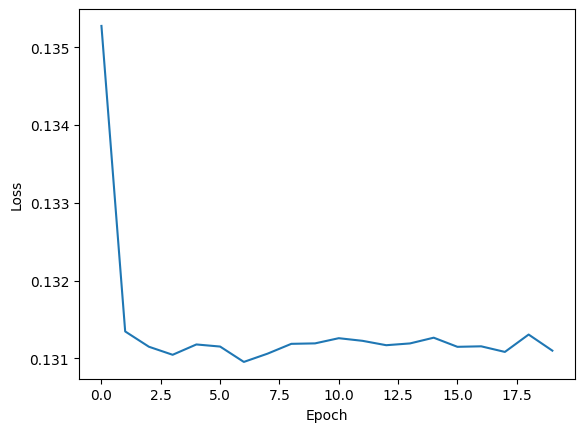

In [26]:
from torch.optim import Adam

net = SimpleNet().to(DEVICE)

# Optimizer and loss
optimizer = Adam(net.parameters(), lr=0.005)
loss_func = nn.MSELoss()

# Training
log = []
net.train()
for epoch in range(20):
    epoch_loss = 0
    for x_batch, y_batch in dataloader:
        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)

        # Forward pass
        y_hat = net(x_batch).squeeze()

        # Calculate loss
        loss = loss_func(y_hat, y_batch)
        epoch_loss += loss.item()

        # Backwards
        net.zero_grad()
        loss.backward()
        optimizer.step()

    # Get average loss over batches
    avg_loss = epoch_loss / len(dataloader)
    log.append(avg_loss)

    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")
print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")

# Plot loss over time
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(log)
plt.show()

#### Simple RNN

In [27]:
DEVICE = torch.device("mps" if torch.backends.mps.is_built() else "cpu")

In [28]:
input_vals = np.array(X_tuple)
print("Input shape", input_vals.shape, "Output shape", ys.shape)

# Standardize the data
from sklearn import preprocessing
for i in tqdm(range(len(input_vals))):
    rows = input_vals[i]
    rows = rows[::-1]  # reverse so that the final pitch is the last row in the dataset
    rows = np.nan_to_num(rows, nan=-1)
    scaler = preprocessing.StandardScaler().fit(rows)
    rows = scaler.transform(rows)
    #rows = torch.tensor(rows, dtype=torch.float32)
    input_vals[i] = rows

Input shape (109608,) Output shape (109608,)


100%|██████████| 109608/109608 [00:18<00:00, 6018.13it/s]


In [29]:
from torch.nn.utils.rnn import pad_sequence

# Convert the list of numpy arrays to a list of tensors
at_bat_tensors = [torch.tensor(at_bat, dtype=torch.float32) for at_bat in input_vals]

# Pad the sequences - (batch_size, max_sequence_length, 12)
padded_at_bats = pad_sequence(at_bat_tensors, batch_first=True, padding_value=0)  # padding_value=0 for zero padding

In [30]:
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split

class BaseballDataset(Dataset):
    def __init__(self, at_bats, targets):
        self.at_bats = at_bats
        self.targets = torch.tensor(targets, dtype=torch.float32)  # Convert target values to tensor

    def __len__(self):
        return len(self.at_bats)

    def __getitem__(self, idx):
        # Return the at-bat sequence and the corresponding target value
        return self.at_bats[idx], self.targets[idx]



# Create Dataset
dataset = BaseballDataset(padded_at_bats, ys)
# Split into test and train data
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
# Turn into Dataloaders
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [31]:
class BaseballRNN1(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BaseballRNN1, self).__init__()

        self.lstm = torch.nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc1 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, output_size)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)
        self.bn1 = nn.BatchNorm1d(hidden_size)

    def forward(self, x):
        # Pass through LSTM
        out, _ = self.lstm(x)

        # Take the output of the last time step
        y = out[:, -1, :]
        
        # Pass through a fully connected layer
        y = self.relu(self.fc1(y))
        y = self.bn1(y)
        y = self.dropout(y)

        y = self.fc2(y)

        return y

In [32]:
class BaseballRNN2(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BaseballRNN2, self).__init__()

        self.lstm = torch.nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc1 = torch.nn.Linear(hidden_size, output_size)

        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(hidden_size)

    def forward(self, x):
        # Pass through LSTM
        out, _ = self.lstm(x)

        # Take the output of the last time step
        y = out[:, -1, :]  # (batch, seq, )
        
        # Pass through a fully connected layer
        y = self.relu(self.fc1(self.bn1(y)))

        return y

In [35]:
# Initialize the model and move it to the appropriate device
model = BaseballRNN2(input_size=12, hidden_size=64, output_size=1).to(DEVICE)

# Define the loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 75
log = []
test_log = []


# Training loop
for epoch in range(num_epochs):
    epoch_loss = 0
    model.train()
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)  # Move inputs and targets to DEVICE
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs).squeeze()
        # Calculate and log loss
        loss = criterion(outputs, targets)
        epoch_loss += loss.item()
        # Backwards pass and step
        loss.backward()
        optimizer.step()

    # Get average loss over batches for training
    avg_train_loss = epoch_loss / len(dataloader)
    log.append(avg_train_loss)

    # Testing loop
    model.eval()
    with torch.no_grad():  # Disable gradients for evaluation
        test_loss = 0
        for inputs, targets in test_dataloader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)  # Ensure test inputs are on the same device
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            test_loss += loss.item()

        # Log average test loss
        avg_test_loss = test_loss / len(test_dataloader)
        test_log.append(avg_test_loss)

    # Print loss every 5 epochs
    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")


# Final output
print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")


Epoch 0, Train Loss: 0.1479, Test Loss: 0.1503
Epoch 5, Train Loss: 0.1441, Test Loss: 0.1485
Epoch 10, Train Loss: 0.1420, Test Loss: 0.1483
Epoch 15, Train Loss: 0.1375, Test Loss: 0.1343
Epoch 20, Train Loss: 0.1291, Test Loss: 0.1262
Epoch 25, Train Loss: 0.1220, Test Loss: 0.1199
Epoch 30, Train Loss: 0.1162, Test Loss: 0.1135
Epoch 35, Train Loss: 0.1113, Test Loss: 0.1075
Epoch 40, Train Loss: 0.1080, Test Loss: 0.1048
Epoch 45, Train Loss: 0.1045, Test Loss: 0.1022
Epoch 50, Train Loss: 0.1020, Test Loss: 0.0986
Epoch 55, Train Loss: 0.0999, Test Loss: 0.0953
Epoch 60, Train Loss: 0.0980, Test Loss: 0.0945
Epoch 65, Train Loss: 0.0967, Test Loss: 0.0921
Epoch 70, Train Loss: 0.0954, Test Loss: 0.0909
Epoch 75, Train Loss: 0.0944, Test Loss: 0.0913


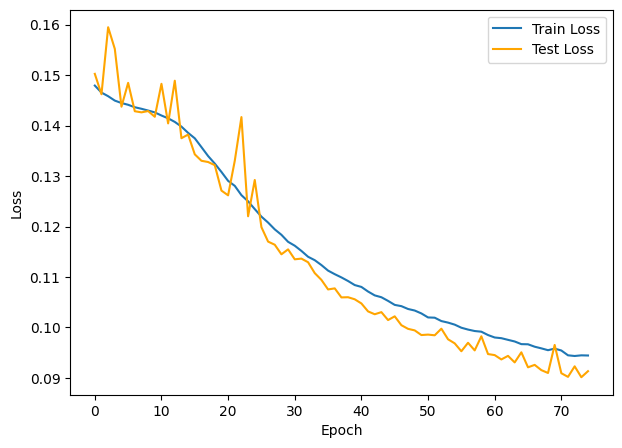

In [36]:
# Plot loss over time
plt.figure(figsize=(7, 5))

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(log, label='Train Loss')
plt.plot(test_log, label='Test Loss', color='orange')
plt.legend()

plt.show()